# Setosa の sepal_length の平均と標準偏差をベイズ推論

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import seaborn as sns
from pandas import infer_freq
from sympy import print_tree
import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
df_iris = sns.load_dataset('iris')  # アイリス・データセット
df_iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [4]:
df_iris['species'].value_counts()  # species の分布確認

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

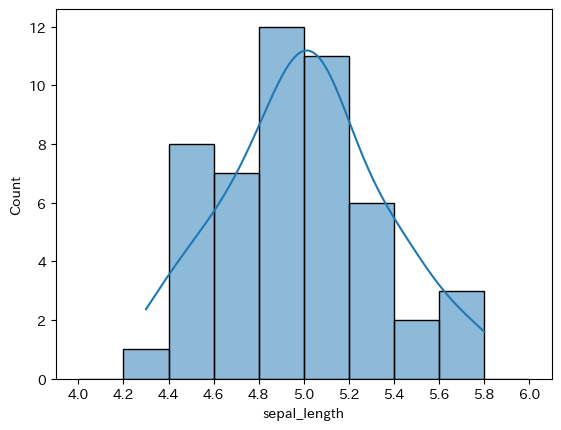

In [6]:
# setosa の sepal_length の値の分布を可視化
df_setosa = df_iris.loc[df_iris['species'] == 'setosa']  # setosa のみ抽出

bins = np.arange(4.0, 6.2, 0.2)  # bin の設定値
sns.histplot(df_setosa, x='sepal_length', bins=bins, kde=True)  # Histogram の描画設定。カーネル密度関数グラフも描画 
plt.xticks(bins)  # x軸の目盛り設定
plt.show()  # 描画

ベイズ推論の結果得られた正規分布関数と、KDE による確率密度関数の形が近いか確認していく。

In [9]:
setosa_sepal_length = df_setosa['sepal_length'].values  # stosa の sepal_length を NumPy の１次元配列として抽出
print(setosa_sepal_length)  # データ確認
df_setosa['sepal_length'].describe()  # 統計情報の確認


[5.1 4.9 4.7 4.6 5.  5.4 4.6 5.  4.4 4.9 5.4 4.8 4.8 4.3 5.8 5.7 5.4 5.1
 5.7 5.1 5.4 5.1 4.6 5.1 4.8 5.  5.  5.2 5.2 4.7 4.8 5.4 5.2 5.5 4.9 5.
 5.5 4.9 4.4 5.1 5.  4.5 4.4 5.  5.1 4.8 5.1 4.6 5.3 5. ]


count    50.00000
mean      5.00600
std       0.35249
min       4.30000
25%       4.80000
50%       5.00000
75%       5.20000
max       5.80000
Name: sepal_length, dtype: float64

In [10]:
# 確率モデル定義
model_setosa_sepal_length = pm.Model()  # インスタンス作成

with model_setosa_sepal_length:
    mu = pm.Normal('mu', mu=0.0, sigma=10.0)  # 平均値の事前分布: 正規分布
    sigma = pm.HalfNormal('sigma', sigma=10.0)  # 標準偏差の事前分布: 半正規分布（※生の値になるため）
    observations = pm.Normal('observations', mu=mu, sigma=sigma, observed=setosa_sepal_length)

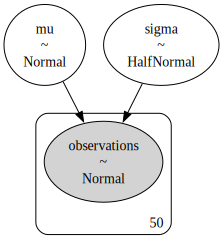

In [11]:
# 確率モデルの可視化
viz_model_setosa_sepal_langth = pm.model_to_graphviz(model_setosa_sepal_length)
viz_model_setosa_sepal_langth

In [12]:
# Sampling
with model_setosa_sepal_length:
    inference_setosa_sepal_length = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


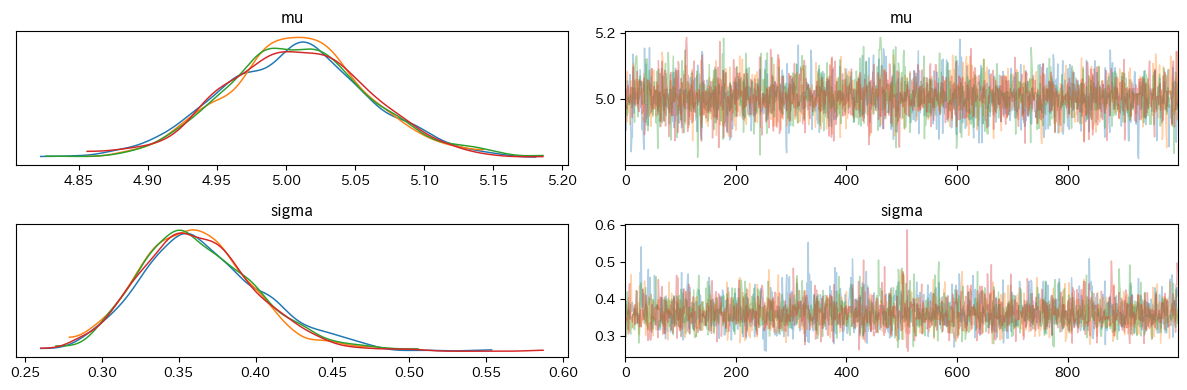

In [14]:
# ベイズ推論の正常性
az.plot_trace(inference_setosa_sepal_length, compact=False)
plt.tight_layout()

うまく収束できている。

In [15]:
inference_setosa_sepal_length

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

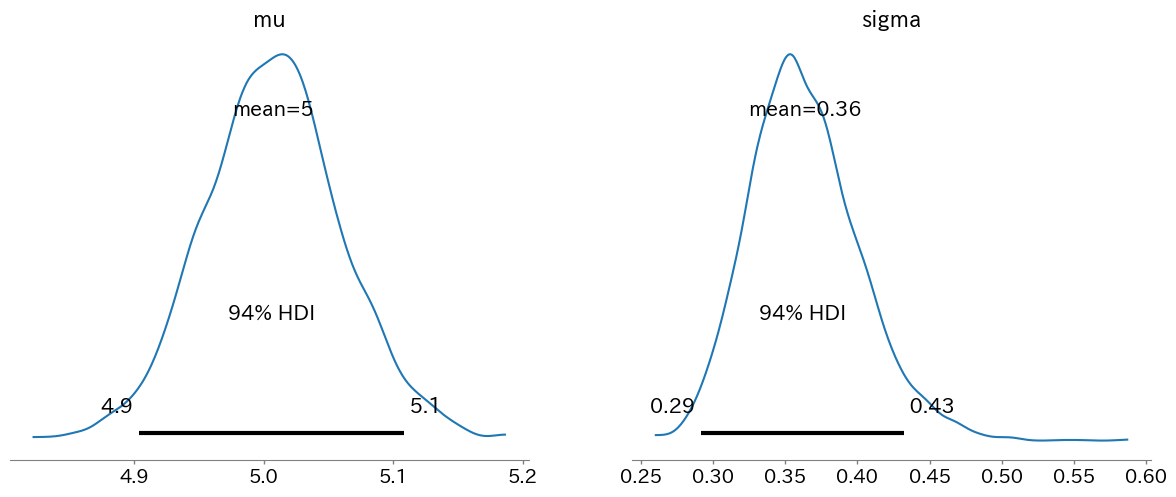

In [16]:
# Sample値の確率分布を可視化
az.plot_posterior(inference_setosa_sepal_length)

In [17]:
# 統計分析
summary_setosa_sepal_length = az.summary(inference_setosa_sepal_length)
summary_setosa_sepal_length

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.007,0.054,4.903,5.108,0.001,0.001,4007.0,2306.0,1.0
sigma,0.363,0.038,0.291,0.432,0.001,0.000,3580.0,2688.0,1.0


- mcse_mean: 0.01以下
- ess_bulk:  400以上
- r_hat:     1.01以下

のため、ベイズ推論はうまくいっていると判断。

## ヒストグラムと正規分布関数の重ね書き

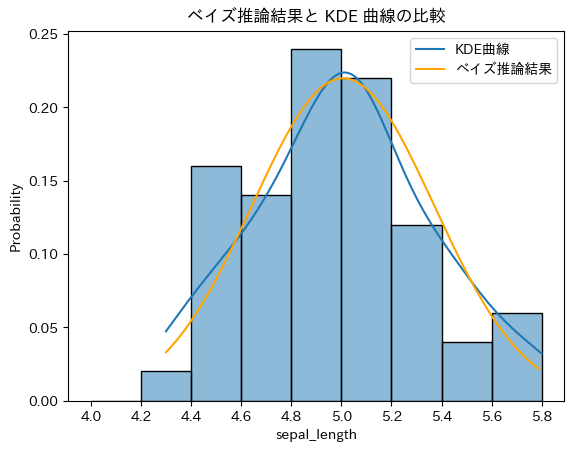

In [24]:
from scipy.stats import norm

# ベイズ推論結果に基づく関数値計算
x_min = setosa_sepal_length.min()
x_max = setosa_sepal_length.max()
list_x = np.arange(x_min, x_max, 0.01)
list_y = norm.pdf(list_x,
                  summary_setosa_sepal_length.loc['mu', 'mean'],
                  summary_setosa_sepal_length.loc['sigma', 'mean'])

# ベイズ推論血管に基づく正規分布関数と KDE 曲線の重ね書き
delta = 0.2
bins = np.arange(4.0, 6.0, delta)
fig, ax = plt.subplots()
sns.histplot(df_setosa, ax=ax, x='sepal_length', bins=bins, kde=True, stat='probability')
ax.get_lines()[0].set_label('KDE曲線')
ax.set_xticks(bins)
ax.plot(list_x, list_y * delta, c='orange', label='ベイズ推論結果')
ax.set_title('ベイズ推論結果と KDE 曲線の比較')
plt.legend()
plt.show()

KDE曲線とベイズ推論から導出した正規分布関数のグラフは近似している。

## 少ないサンプル数でベイズ推論
ベイズ推論は、
- サンプル数が少ない
- 統計的に厳しい条件

でも比較的精度の高い推論ができる

In [26]:
setosa_sepal_length_small = setosa_sepal_length[:5]  # サンプル数を５件に
print(setosa_sepal_length_small)
pd.Series(setosa_sepal_length_small).describe()  # 統計値確認

[5.1 4.9 4.7 4.6 5. ]


count    5.000000
mean     4.860000
std      0.207364
min      4.600000
25%      4.700000
50%      4.900000
75%      5.000000
max      5.100000
dtype: float64

In [27]:
# 確率モデル定義
model_setosa_sepal_length_small = pm.Model()

with model_setosa_sepal_length_small:
    mu    = pm.Normal('mu', mu=0.0, sigma=10.0)
    sigma = pm.HalfNormal('sigma', sigma=10.0)
    obs_setosa_sepal_length_small = pm.Normal('obs_setosa_sepal_length_small', mu=mu, sigma=sigma, observed=setosa_sepal_length_small)
    
    # Samling
    inference_setosa_sepal_length_small = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


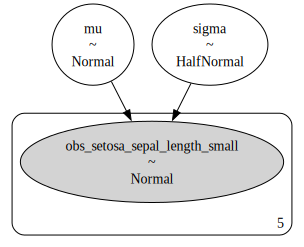

In [28]:
# 確率モデル可視化
viz_model_setosa_sepal_langth_small = pm.model_to_graphviz(model_setosa_sepal_length_small)
viz_model_setosa_sepal_langth_small

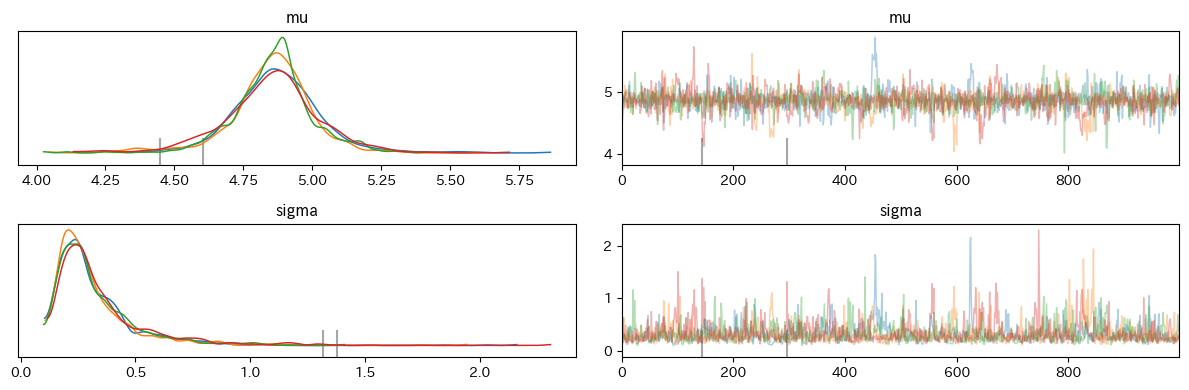

In [29]:
# Sampling の正常性
az.plot_trace(inference_setosa_sepal_length_small, compact=False)
plt.tight_layout()

少しあらいが、うまく収束できていると判断。

In [30]:
# 統計分析
summary_setosa_sepal_length_small = az.summary(inference_setosa_sepal_length_small)
summary_setosa_sepal_length_small

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.860,0.160,4.540,5.154,0.005,0.003,1283.0,1099.0,1.0
sigma,0.325,0.188,0.113,0.650,0.007,0.005,938.0,1086.0,1.0


- mcse_mean: 0.01以下
- ess_bulk:  400 以上
- r_hat: 1.01以下

のため、うまく推論できていると判断

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

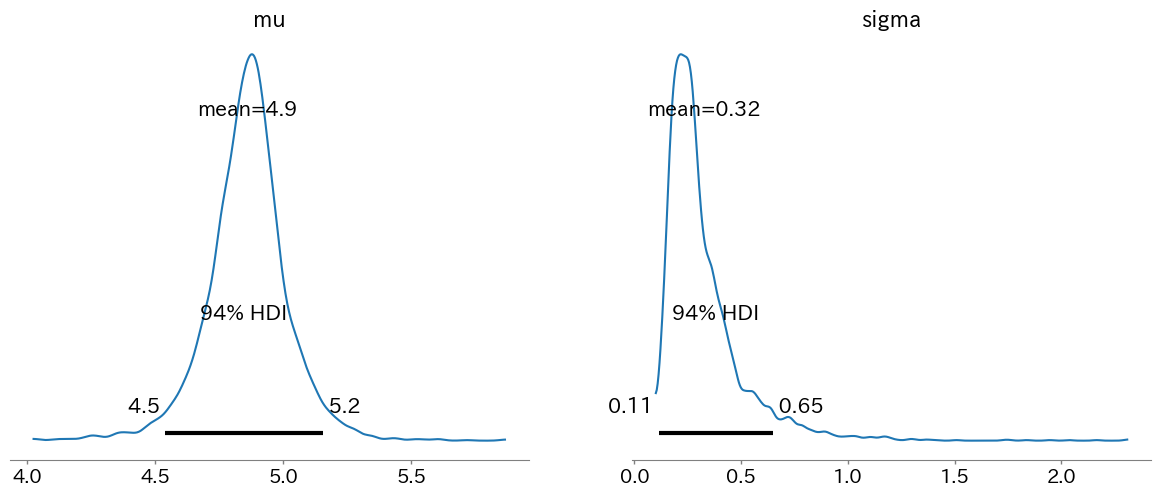

In [31]:
# サンプリング結果の可視化
az.plot_posterior(inference_setosa_sepal_length_small)

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

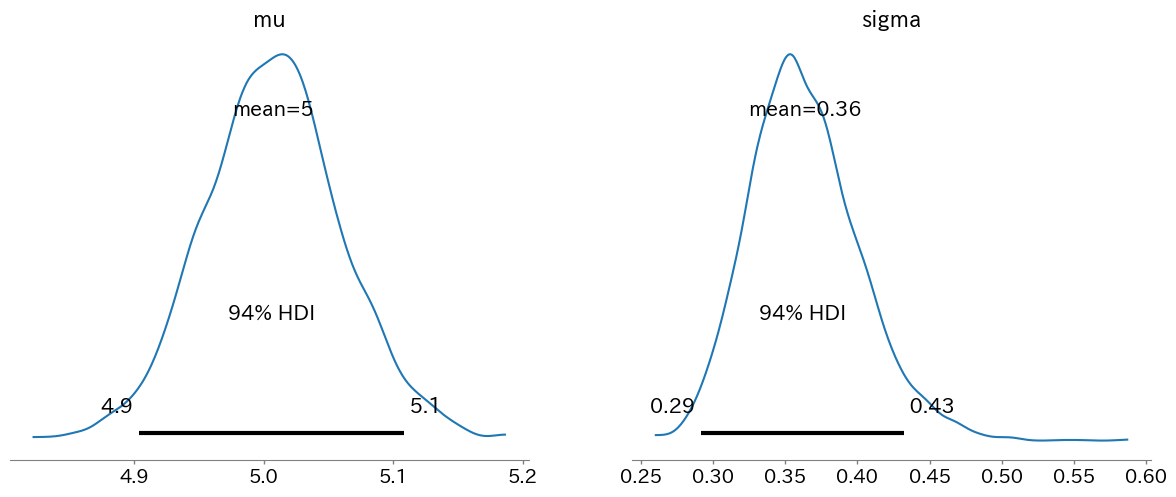

In [33]:
az.plot_posterior(inference_setosa_sepal_length)  # サンプル数: 50 を再掲

- `mu`, `sigma` の平均値はサンプル数50 の時から大きく変化なし。
- 94%HDI は広がっている（とくに `sigma`）

# tau で確率モデルを定義し推論
- `pm.Normal`　クラスのパラメータを `sigma` から `tau` に変えて推論して結果を比較してみる。
- `tau` と `sigma` の関係式: $\tau = \frac{1}{\sigma^2}$


In [34]:
# 確率モデル定義
model_setosa_sepal_length_tau = pm.Model()

with model_setosa_sepal_length_tau:
    mu = pm.Normal('mu', mu=0.0, sigma=10.0)
    tau = pm.HalfNormal('tau', sigma=10.0)
    obs_setosa_sepal_length_tau = pm.Normal('obs_setosa_sepal_length_tau', mu=mu, tau=tau, observed=setosa_sepal_length)
    sigma = pm.Deterministic('sigma', 1 / pm.math.sqrt(tau))
    
    # Sampling
    inference_setosa_sepal_length_tau = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


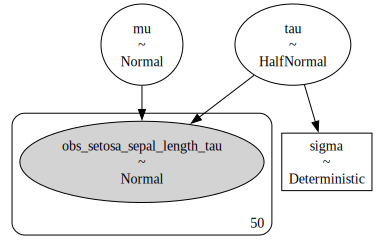

In [35]:
# 確率モデル可視化
viz_model_setosa_sepal_langth_tau = pm.model_to_graphviz(model_setosa_sepal_length_tau)
viz_model_setosa_sepal_langth_tau

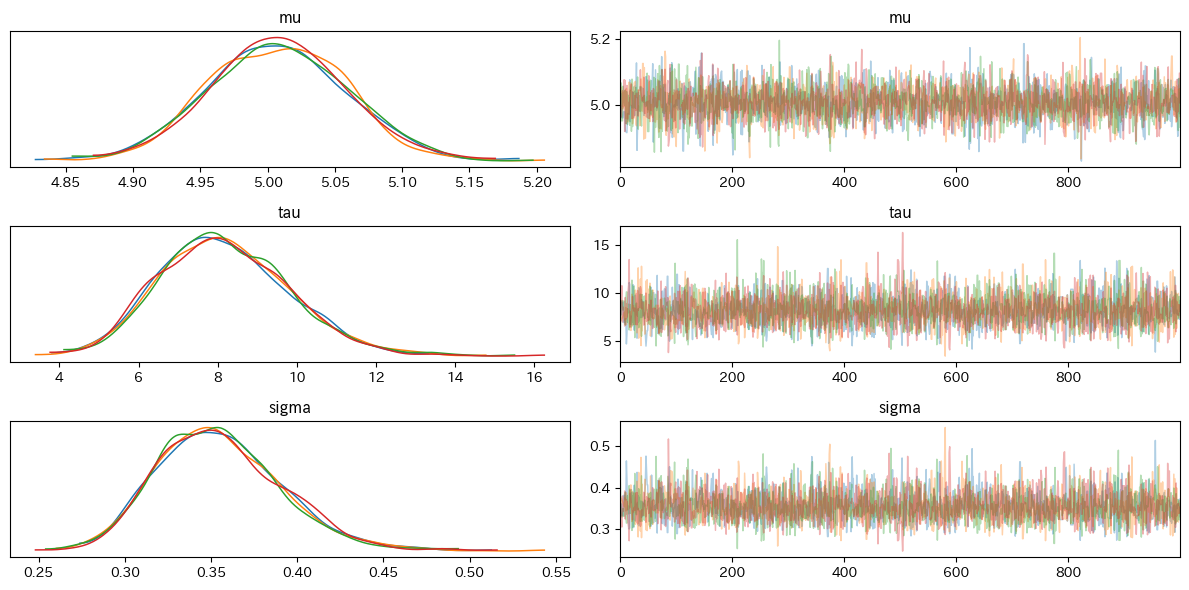

In [36]:
# 収束具体の可視化
az.plot_trace(inference_setosa_sepal_length_tau, compact=False)
plt.tight_layout()

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'tau'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

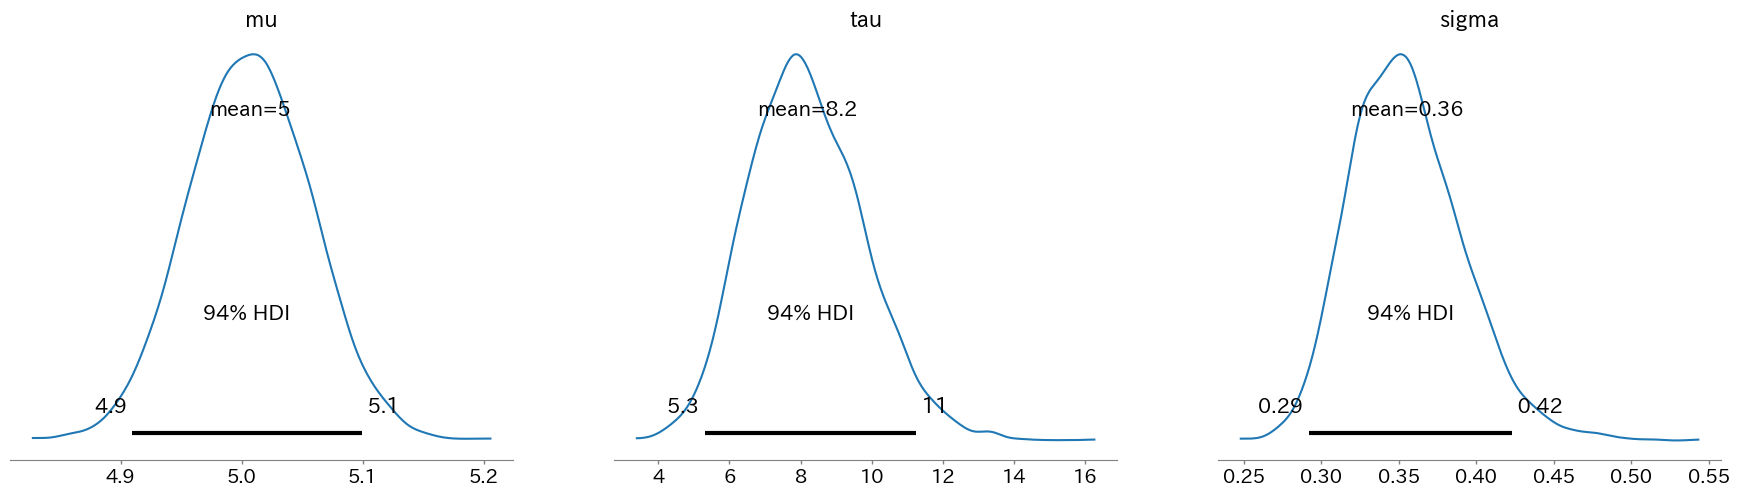

In [37]:
# サンプリングの確率分布を可視化
az.plot_posterior(inference_setosa_sepal_length_tau)

In [38]:
# 統計分析
summary_setosa_sepal_length_tau = az.summary(inference_setosa_sepal_length_tau)
summary_setosa_sepal_length_tau

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.007,0.051,4.910,5.099,0.001,0.001,4258.0,2632.0,1.0
tau,8.172,1.621,5.301,11.235,0.026,0.018,4078.0,2623.0,1.0
sigma,0.355,0.036,0.292,0.423,0.001,0.000,4078.0,2623.0,1.0


`mu` の分布について、`sigma` を用いてサンプリングした時とほぼ同等の結果になっている。   
今回のケースでは解釈しやすい `sigma` を用いた方が分かりやすさの観点で Better.     
※確率モデルの構造によっては、結果に大きな違いが出る場合もある。